In [1]:
import os
for dirname, _,filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname,filename))

/kaggle/input/news-classification-and-analysis-using-nlp/english_news_dataset.csv


In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import regex
import re
from nltk import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [3]:
df=pd.read_csv('/kaggle/input/news-classification-and-analysis-using-nlp/english_news_dataset.csv')
df.shape

(199706, 4)

In [4]:
df.head()

,Headline,Content,News Categories,Date
0,Congress leader Baljinder Singh shot dead at h...,Congress leader Baljinder Singh was shot dead ...,['national'],19-09-2023
1,17-year-old girl preparing for NEET dies by su...,Another NEET aspirant died by suicide in Rajas...,['national'],19-09-2023
2,Hampers to welcome MPs in new Parliament tomor...,In order to mark the first-ever working day of...,['national'],19-09-2023
3,"Only 10% women lawmakers in RS, while only 14%...","Congress President Mallikarjun Kharge, while s...",['national'],19-09-2023
4,"Ganesh temple decorated with notes, coins wort...",The Sri Sathya Ganapathi Temple in Bengaluru a...,['national'],19-09-2023


# Category Grouped

In [5]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
threshold = 5

# Identify classes with fewer instances
class_counts = df['News Categories'].value_counts()
rare_classes = class_counts[class_counts < threshold].index

# Group rare classes into a broader category 'Other'
df['category_grouped'] = df['News Categories'].apply(lambda x: 'Other' if x in rare_classes else x)

In [6]:
df["News Categories"]

0                            ['national']
1                            ['national']
2                            ['national']
3                            ['national']
4                            ['national']
                       ...               
199701    ['science', 'Health___Fitness']
199702    ['science', 'Health___Fitness']
199703               ['Health___Fitness']
199704    ['science', 'Health___Fitness']
199705               ['Health___Fitness']
Name: News Categories, Length: 199706, dtype: object

In [7]:
df['category_grouped']

0                            ['national']
1                            ['national']
2                            ['national']
3                            ['national']
4                            ['national']
                       ...               
199701    ['science', 'Health___Fitness']
199702    ['science', 'Health___Fitness']
199703               ['Health___Fitness']
199704    ['science', 'Health___Fitness']
199705               ['Health___Fitness']
Name: category_grouped, Length: 199706, dtype: object

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199706 entries, 0 to 199705
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Headline          199706 non-null  object
 1   Content           199706 non-null  object
 2   News Categories   199706 non-null  object
 3   Date              199706 non-null  object
 4   category_grouped  199706 non-null  object
dtypes: object(5)
memory usage: 7.6+ MB


In [9]:
df.isnull().sum()

Headline            0
Content             0
News Categories     0
Date                0
category_grouped    0
dtype: int64

In [10]:
df.duplicated().sum()

35452

In [11]:
df["Date"].head()

0    19-09-2023
1    19-09-2023
2    19-09-2023
3    19-09-2023
4    19-09-2023
Name: Date, dtype: object

In [12]:
df["News Categories"].unique().sum()

"['national']['entertainment', 'national']['politics', 'national']['world', 'national']['national', 'technology']['business', 'national']['sports', 'national']['world', 'national', 'Health___Fitness']['national', 'Health___Fitness']['business', 'technology']['business']['business', 'startup']['automobile', 'business', 'technology']['business', 'fashion']['world', 'business']['world', 'business', 'technology']['automobile', 'business']['business', 'entertainment', 'national']['world', 'business', 'national']['business', 'science', 'technology']['cryptocurrency', 'business', 'technology']['automobile', 'business', 'national']['politics']['politics', 'sports', 'Asia_Cup_2023']['politics', 'entertainment']['sports']['sports', 'entertainment']['sports', 'Asia_Cup_2023']['Asia_Cup_2023', 'sports']['sports', 'Asia_Cup_2023', 'entertainment']['technology']['world', 'technology']['cryptocurrency', 'technology']['science', 'technology']['entertainment', 'technology']['sports', 'technology']['aut

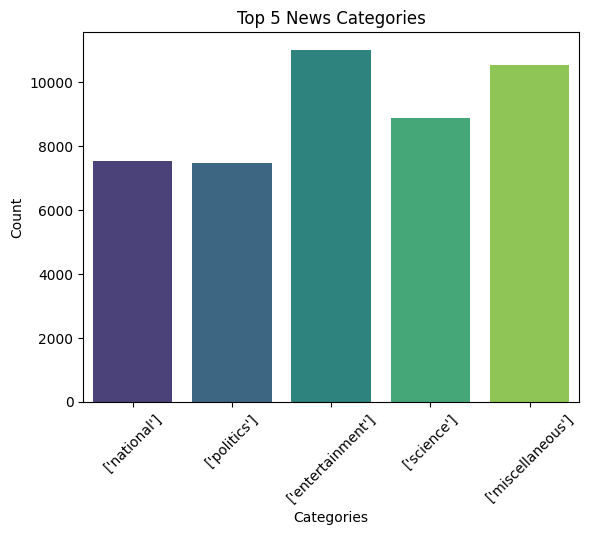

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
top_n = 5
top_categories = df['News Categories'].value_counts().nlargest(top_n).index

df_top = df[df['News Categories'].isin(top_categories)]

sns.countplot(x='News Categories', data=df_top, palette='viridis')
plt.title(f'Top {top_n} News Categories')
plt.xlabel('Categories')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show();

In [14]:
df['News Categories']

0                            ['national']
1                            ['national']
2                            ['national']
3                            ['national']
4                            ['national']
                       ...               
199701    ['science', 'Health___Fitness']
199702    ['science', 'Health___Fitness']
199703               ['Health___Fitness']
199704    ['science', 'Health___Fitness']
199705               ['Health___Fitness']
Name: News Categories, Length: 199706, dtype: object

In [15]:
import string
string.punctuation
punc=string.punctuation

In [16]:
def remove_punc(text):
    return text.translate(str.maketrans('', '',punc))

df["News Categories"]=df["News Categories"].apply(remove_punc)
df.head()

,Headline,Content,News Categories,Date,category_grouped
0,Congress leader Baljinder Singh shot dead at h...,Congress leader Baljinder Singh was shot dead ...,national,19-09-2023,['national']
1,17-year-old girl preparing for NEET dies by su...,Another NEET aspirant died by suicide in Rajas...,national,19-09-2023,['national']
2,Hampers to welcome MPs in new Parliament tomor...,In order to mark the first-ever working day of...,national,19-09-2023,['national']
3,"Only 10% women lawmakers in RS, while only 14%...","Congress President Mallikarjun Kharge, while s...",national,19-09-2023,['national']
4,"Ganesh temple decorated with notes, coins wort...",The Sri Sathya Ganapathi Temple in Bengaluru a...,national,19-09-2023,['national']


In [17]:
df['Date'] = pd.to_datetime(df['Date'],format='mixed',dayfirst=True)

df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

df.head()

,Headline,Content,News Categories,Date,category_grouped,year,month,day
0,Congress leader Baljinder Singh shot dead at h...,Congress leader Baljinder Singh was shot dead ...,national,2023-09-19,['national'],2023,9,19
1,17-year-old girl preparing for NEET dies by su...,Another NEET aspirant died by suicide in Rajas...,national,2023-09-19,['national'],2023,9,19
2,Hampers to welcome MPs in new Parliament tomor...,In order to mark the first-ever working day of...,national,2023-09-19,['national'],2023,9,19
3,"Only 10% women lawmakers in RS, while only 14%...","Congress President Mallikarjun Kharge, while s...",national,2023-09-19,['national'],2023,9,19
4,"Ganesh temple decorated with notes, coins wort...",The Sri Sathya Ganapathi Temple in Bengaluru a...,national,2023-09-19,['national'],2023,9,19


In [18]:
df=df.drop('Date',axis=1)

In [19]:
df.head()

,Headline,Content,News Categories,category_grouped,year,month,day
0,Congress leader Baljinder Singh shot dead at h...,Congress leader Baljinder Singh was shot dead ...,national,['national'],2023,9,19
1,17-year-old girl preparing for NEET dies by su...,Another NEET aspirant died by suicide in Rajas...,national,['national'],2023,9,19
2,Hampers to welcome MPs in new Parliament tomor...,In order to mark the first-ever working day of...,national,['national'],2023,9,19
3,"Only 10% women lawmakers in RS, while only 14%...","Congress President Mallikarjun Kharge, while s...",national,['national'],2023,9,19
4,"Ganesh temple decorated with notes, coins wort...",The Sri Sathya Ganapathi Temple in Bengaluru a...,national,['national'],2023,9,19


# Text preperation

##1- lower case

In [20]:
df["Content"]=df["Content"].str.lower()
df.head()

,Headline,Content,News Categories,category_grouped,year,month,day
0,Congress leader Baljinder Singh shot dead at h...,congress leader baljinder singh was shot dead ...,national,['national'],2023,9,19
1,17-year-old girl preparing for NEET dies by su...,another neet aspirant died by suicide in rajas...,national,['national'],2023,9,19
2,Hampers to welcome MPs in new Parliament tomor...,in order to mark the first-ever working day of...,national,['national'],2023,9,19
3,"Only 10% women lawmakers in RS, while only 14%...","congress president mallikarjun kharge, while s...",national,['national'],2023,9,19
4,"Ganesh temple decorated with notes, coins wort...",the sri sathya ganapathi temple in bengaluru a...,national,['national'],2023,9,19


# 2- remove html tags

In [21]:
# !pip install beautifulsoup4

In [22]:
from bs4 import BeautifulSoup

## check if there is html tags

def has_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    return bool(soup.find())

df['has_html_tags'] = df['Content'].apply(has_html_tags)

In [23]:
df.head()

,Headline,Content,News Categories,category_grouped,year,month,day,has_html_tags
0,Congress leader Baljinder Singh shot dead at h...,congress leader baljinder singh was shot dead ...,national,['national'],2023,9,19,False
1,17-year-old girl preparing for NEET dies by su...,another neet aspirant died by suicide in rajas...,national,['national'],2023,9,19,False
2,Hampers to welcome MPs in new Parliament tomor...,in order to mark the first-ever working day of...,national,['national'],2023,9,19,False
3,"Only 10% women lawmakers in RS, while only 14%...","congress president mallikarjun kharge, while s...",national,['national'],2023,9,19,False
4,"Ganesh temple decorated with notes, coins wort...",the sri sathya ganapathi temple in bengaluru a...,national,['national'],2023,9,19,False


In [24]:
count_true = df['has_html_tags'].sum()
count_true

0

In [25]:
df = df.drop('has_html_tags', axis=1)
df

,Headline,Content,News Categories,category_grouped,year,month,day
0,Congress leader Baljinder Singh shot dead at h...,congress leader baljinder singh was shot dead ...,national,['national'],2023,9,19
1,17-year-old girl preparing for NEET dies by su...,another neet aspirant died by suicide in rajas...,national,['national'],2023,9,19
2,Hampers to welcome MPs in new Parliament tomor...,in order to mark the first-ever working day of...,national,['national'],2023,9,19
3,"Only 10% women lawmakers in RS, while only 14%...","congress president mallikarjun kharge, while s...",national,['national'],2023,9,19
4,"Ganesh temple decorated with notes, coins wort...",the sri sathya ganapathi temple in bengaluru a...,national,['national'],2023,9,19
...,...,...,...,...,...,...,...
199701,Cause for age related diabetes can be pancreat...,"the pancreas is an incredibly important organ,...",science HealthFitness,"['science', 'Health___Fitness']",2024,1,20
199702,Study unveils Why sugary drinks may be bad for...,a recent study published in oral diseases has...,science HealthFitness,"['science', 'Health___Fitness']",2024,1,20
199703,Why do Hospital-acquired infections happen? Ex...,hospital-acquired infections (hais) refer to i...,HealthFitness,['Health___Fitness'],2024,1,20
199704,Oxford launches first human vaccine trials for...,scientists at the university of oxford in the ...,science HealthFitness,"['science', 'Health___Fitness']",2024,1,20


# 3- remove emojies

In [26]:
# !pip install emoji

In [27]:
# !pip install --upgrade emoji

In [28]:
# !pip install regex

In [29]:
import regex
def has_emoji(text):
    emoji_pattern = regex.compile(r'\p{Emoji}', flags=regex.UNICODE)
    return bool(emoji_pattern.search(text))


has_emojis =  df['Content'].apply(has_emoji)

has_emojis

0         False
1          True
2         False
3          True
4          True
          ...  
199701    False
199702    False
199703    False
199704     True
199705    False
Name: Content, Length: 199706, dtype: bool

In [30]:
has_emojis.sum()

127178

In [31]:
def remove_emojis(text):
    emoji_pattern = regex.compile(r'\p{Emoji}', flags=regex.UNICODE)
    return emoji_pattern.sub('', text)

df['Content'] = df['Content'].apply(remove_emojis)

In [32]:
has_emojis =  df['Content'].apply(has_emoji)
has_emojis

0         False
1         False
2         False
3         False
4         False
          ...  
199701    False
199702    False
199703    False
199704    False
199705    False
Name: Content, Length: 199706, dtype: bool

In [33]:
has_emojis.sum()

0

# 4- remove urls

In [34]:
import re
def remove_url(text):
    pattern=re.compile(r'https?://\S+|www\.S+')
    return pattern.sub(r'',text)
df["Content"]=df["Content"].apply(remove_url)

# Remove punctuation

In [35]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [36]:
punc=string.punctuation

In [37]:
def remove_punc(text):
    return text.translate(str.maketrans('', '',punc))
df["Content"]=df["Content"].apply(remove_punc)

# remove stopwords

In [38]:
from nltk.corpus import stopwords

In [39]:
import nltk

In [40]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
stop_words=set(stopwords.words('english'))

In [42]:
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

df["Content"]=df["Content"].apply(lambda x: remove_stopwords(x))

# Remove abbreviations

In [43]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [44]:
abbreviation_dict = {
    'LOL': 'laugh out loud',
    'BRB': 'be right back',
    'OMG': 'oh my god',
    'AFAIK': 'as far as I know',
    'AFK': 'away from keyboard',
    'ASAP': 'as soon as possible',
    'ATK': 'at the keyboard',
    'ATM': 'at the moment',
    'A3': 'anytime, anywhere, anyplace',
    'BAK': 'back at keyboard',
    'BBL': 'be back later',
    'BBS': 'be back soon',
    'BFN': 'bye for now',
    'B4N': 'bye for now',
    'BRB': 'be right back',
    'BRT': 'be right there',
    'BTW': 'by the way',
    'B4': 'before',
    'B4N': 'bye for now',
    'CU': 'see you',
    'CUL8R': 'see you later',
    'CYA': 'see you',
    'FAQ': 'frequently asked questions',
    'FC': 'fingers crossed',
    'FWIW': 'for what it\'s worth',
    'FYI': 'For Your Information',
    'GAL': 'get a life',
    'GG': 'good game',
    'GN': 'good night',
    'GMTA': 'great minds think alike',
    'GR8': 'great!',
    'G9': 'genius',
    'IC': 'i see',
    'ICQ': 'i seek you',
    'ILU': 'i love you',
    'IMHO': 'in my honest/humble opinion',
    'IMO': 'in my opinion',
    'IOW': 'in other words',
    'IRL': 'in real life',
    'KISS': 'keep it simple, stupid',
    'LDR': 'long distance relationship',
    'LMAO': 'laugh my a.. off',
    'LOL': 'laughing out loud',
    'LTNS': 'long time no see',
    'L8R': 'later',
    'MTE': 'my thoughts exactly',
    'M8': 'mate',
    'NRN': 'no reply necessary',
    'OIC': 'oh i see',
    'PITA': 'pain in the a..',
    'PRT': 'party',
    'PRW': 'parents are watching',
    'QPSA?': 'que pasa?',
    'ROFL': 'rolling on the floor laughing',
    'ROFLOL': 'rolling on the floor laughing out loud',
    'ROTFLMAO': 'rolling on the floor laughing my a.. off',
    'SK8': 'skate',
    'STATS': 'your sex and age',
    'ASL': 'age, sex, location',
    'THX': 'thank you',
    'TTFN': 'ta-ta for now!',
    'TTYL': 'talk to you later',
    'U': 'you',
    'U2': 'you too',
    'U4E': 'yours for ever',
    'WB': 'welcome back',
    'WTF': 'what the f...',
    'WTG': 'way to go!',
    'WUF': 'where are you from?',
    'W8': 'wait...',
    '7K': 'sick laughter',
    'TFW': 'that feeling when',
    'MFW': 'my face when',
    'MRW': 'my reaction when',
    'IFYP': 'i feel your pain',
    'LOL': 'laughing out loud',
    'TNTL': 'trying not to laugh',
    'JK': 'just kidding',
    'IDC': 'i don’t care',
    'ILY': 'i love you',
    'IMU': 'i miss you',
    'ADIH': 'another day in hell',
    'IDC': 'i don’t care',
    'ZZZ': 'sleeping, bored, tired',
    'WYWH': 'wish you were here',
    'TIME': 'tears in my eyes',
    'BAE': 'before anyone else',
    'FIMH': 'forever in my heart',
    'BSAAW': 'big smile and a wink',
    'BWL': 'bursting with laughter',
    'LMAO': 'laughing my a** off',
    'BFF': 'best friends forever',
    'CSL': 'can’t stop laughing',
}

In [45]:
def replace_abbreviations(text, abbreviation_dict):
    for abbreviation, full_form in abbreviation_dict.items():
        text = text.replace(abbreviation, full_form)
    return text
df['Content'] = df['Content'].apply(lambda x: replace_abbreviations(x,abbreviation_dict))

In [46]:
df.head()

,Headline,Content,News Categories,category_grouped,year,month,day
0,Congress leader Baljinder Singh shot dead at h...,congress leader baljinder singh shot dead hous...,national,['national'],2023,9,19
1,17-year-old girl preparing for NEET dies by su...,another neet aspirant died suicide rajasthans ...,national,['national'],2023,9,19
2,Hampers to welcome MPs in new Parliament tomor...,order mark firstever working day new parliamen...,national,['national'],2023,9,19
3,"Only 10% women lawmakers in RS, while only 14%...",congress president mallikarjun kharge speaking...,national,['national'],2023,9,19
4,"Ganesh temple decorated with notes, coins wort...",sri sathya ganapathi temple bengaluru adorned ...,national,['national'],2023,9,19


## Tokeinization

In [47]:
import nltk
nltk.download('punkt')
from nltk import word_tokenize , sent_tokenize

def tokenize_text(text):
    # Tokenize each sentence into words
    words_list = [word_tokenize(sentence) for sentence in sent_tokenize(text)]

    words = ' '.join(' '.join(words) for words in words_list)

    return words

df["Content"] = df["Content"].apply(tokenize_text)

df.head()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Headline,Content,News Categories,category_grouped,year,month,day
0,Congress leader Baljinder Singh shot dead at h...,congress leader baljinder singh shot dead hous...,national,['national'],2023,9,19
1,17-year-old girl preparing for NEET dies by su...,another neet aspirant died suicide rajasthans ...,national,['national'],2023,9,19
2,Hampers to welcome MPs in new Parliament tomor...,order mark firstever working day new parliamen...,national,['national'],2023,9,19
3,"Only 10% women lawmakers in RS, while only 14%...",congress president mallikarjun kharge speaking...,national,['national'],2023,9,19
4,"Ganesh temple decorated with notes, coins wort...",sri sathya ganapathi temple bengaluru adorned ...,national,['national'],2023,9,19


## Split data

In [48]:
!pip install imbalanced-learn

In [49]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [50]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

X = df['Content']
y = df['category_grouped']

# Encoding labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

class_weights_train = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)

In [51]:
X

0         congress leader baljinder singh shot dead hous...
1         another neet aspirant died suicide rajasthans ...
2         order mark firstever working day new parliamen...
3         congress president mallikarjun kharge speaking...
4         sri sathya ganapathi temple bengaluru adorned ...
                                ...                        
199701    pancreas incredibly important organ particular...
199702    recent study published oral diseases reported ...
199703    hospitalacquired infections hais refer infecti...
199704    scientists university oxford uk launched first...
199705    high blood pressure happens force blood pushin...
Name: Content, Length: 199706, dtype: object

In [52]:
y.shape

(199706,)

In [53]:
y_encoded

array([284, 284, 284, ...,  72, 346,  72])

In [54]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Modeling

## BOW

In [55]:
# Multinomial Naive Bayes with Bag of Words
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score,classification_report


model = make_pipeline(CountVectorizer(), MultinomialNB())

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"MultinomialNB with Bag of Words accuracy: {accuracy:.3f}")
# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

MultinomialNB with Bag of Words accuracy: 0.892
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00         8
           2       1.00      1.00      1.00        11
           3       1.00      0.83      0.91        30
           4       1.00      1.00      1.00         9
           5       0.00      0.00      0.00         7
           6       0.00      0.00      0.00         1
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00        18
           9       1.00      0.71      0.83         7
          10       0.00      0.00      0.00         2
          11       1.00      1.00      1.00         2
          12       1.00      1.00      1.00        15
          13       0.00      0.00      0.00         7
          14       1.00      1.00      1.00        10
          15       1.00      1.00      1.00         6
         

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Cross-validation

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

cv_scores = cross_val_score(model, X, y_encoded, cv=StratifiedKFold(n_splits=3, shuffle=True), scoring='accuracy')

print(f"Cross-Validation Scores:{cv_scores}")

print(f"Mean Accuracy: {np.mean(cv_scores):.2f}")

Cross-Validation Scores:[0.87907284 0.88003425 0.88290169]
Mean Accuracy: 0.88


## Fine-tuning

In [57]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'countvectorizer__max_features': [5000, 10000, None],
    'countvectorizer__ngram_range': [(1, 1), (1, 2)],
    'multinomialnb__alpha': uniform(0.1, 2.0)  # Example range for alpha
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=5, scoring='accuracy', cv=cv, verbose=1, n_jobs=1)
random_search.fit(X, y_encoded)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer()),
                                             ('multinomialnb',
                                              MultinomialNB())]),
                   n_iter=5, n_jobs=1,
                   param_distributions={'countvectorizer__max_features': [5000,
                                                                          10000,
                                                                          None],
                                        'countvectorizer__ngram_range': [(1, 1),
                                                                         (1,
                                                                          2)],
                                        'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b7406711d50>},
                   scoring='accuracy', verbose=1)

In [58]:
best_params = random_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'countvectorizer__max_features': None, 'countvectorizer__ngram_range': (1, 1), 'multinomialnb__alpha': 0.8362174292388217}


In [59]:
best_model = random_search.best_estimator_

best_model.fit(X_train, y_train)

y_pred_best = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_best)

print(f"Best Model Accuracy: {accuracy:.3f}")

Best Model Accuracy: 0.902


# Error Analysis

In [60]:
# Inverse transform the predicted labels to get the original class labels
predicted_labels_original = le.inverse_transform(y_pred_best)

In [61]:
correct_predictions = sum(y_test == y_pred_best)
wrong_predictions = len(y_test) - correct_predictions
print(f'Correct Predictions: {correct_predictions}, Wrong Predictions: {wrong_predictions}')

Correct Predictions: 36013, Wrong Predictions: 3929


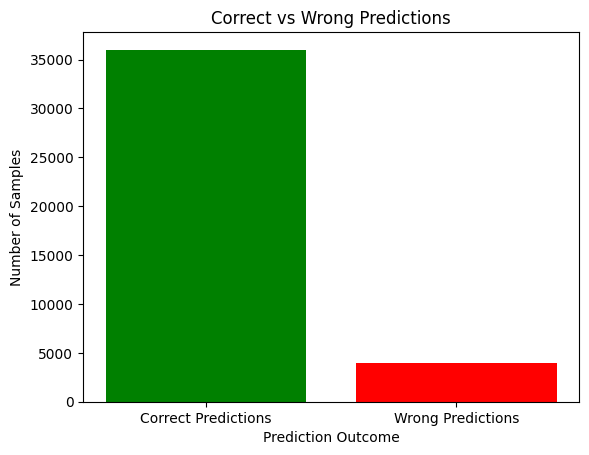

In [62]:
labels = ['Correct Predictions', 'Wrong Predictions']
values = [correct_predictions, wrong_predictions]

plt.bar(labels, values, color=['green', 'red'])
plt.title('Correct vs Wrong Predictions')
plt.xlabel('Prediction Outcome')
plt.ylabel('Number of Samples')
plt.show()

## Final Dataframe

In [63]:
#final dataframe with text and predicted labels
final_df = pd.DataFrame({'Content': X_test, 'Predicted_Labels': predicted_labels_original, 'Actual_Labels': le.inverse_transform(y_test)})

final_df.head()

,Content,Predicted_Labels,Actual_Labels
23219,congress sandeep dikshit monday asked aimim ch...,['politics'],['politics']
48597,square ceo alyssa henry stepping nine years pa...,"['business', 'startup']","['business', 'startup']"
162019,every womans menstruation cycle reflects certa...,['Health___Fitness'],['Health___Fitness']
35753,jonty rhodes superman runout inzamamulhaq worl...,"['sports', 'ODI_World_Cup_2023']","['sports', 'ODI_World_Cup_2023']"
108844,cartrade technologies reported yoy surge profi...,"['business', 'startup', 'technology']","['business', 'startup', 'technology']"


## findings and insights :
* 1- using BOW rather that TF-IDF bec BOW have highest acc than TF-IDF 
* 2- use those hyperparamters [max_feature=None , ngram_range=(1,2) , alpha=0.1116] to get the accuracy 0.984
* 3- after using the best model the Correct predictions = 39300 (thats very good) & the wrong predictions are : 642
* 4- using other models may be give high accuracy and Correct predections